In [94]:
from helpers import *
import pandas as pd
from xgboost import XGBRegressor
import seaborn as sns
import matplotlib.pyplot as plt
import random
import warnings 
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# ignore warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# auto reloading library (mainly for altering helpers.py)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [95]:
pd.set_option('display.max_columns', None)

In [96]:
training_filters = [
    {
        'feature': 'month',
        'operator': 'between',
        'value': [3, 9]
    }
]

validation_filters = [
    {
        'feature': 'date_forecast',
        'operator': 'between',
        'value': ['2020-05-01', '2020-07-01']
    }
]

test_filters = [
    {
        'feature': 'date_forecast',
        'operator': 'between',
        'value': ['2021-05-01', '2021-07-01']
    }
]

In [97]:
predictions = []

# Model 1
use as many columns as possbile
xgboost

In [98]:
agg_strats = ['mean','00','15','30','45','min','max','std','median']

m_wrap = DataWrapper(
    impute_strategy = 'fbfill',
    aggregation_strats = agg_strats,
    y_scalers = [Y_Scaler_MaxAbs_per_building()],
    transform_pred_strategy = ['clip','sun_el_thr'],
    training_filters=training_filters,
    validation_filters=validation_filters,
    test_filters=test_filters,
    bagging_filters=False, # these are applied additionally to the other filters on val, test, sub
    )

X_train_agg, y_train_agg = m_wrap.get_train(aggregated=True,drop_val=False,drop_test=False,y_scaled=True)
X_train_agg = X_train_agg.select_dtypes(exclude=['datetime','timedelta','period[M]'])

X_sub_agg = m_wrap.get_sub(aggregated=True)

# automatically set types of columns for imputing and oneHotEncoding
categorical_features = X_train_agg.select_dtypes(include=['object']).columns.tolist()
impute_features = X_train_agg.loc[:, X_train_agg.isna().any()].columns.tolist()

# automatically set types of columns for imputing and oneHotEncoding
columnTransformer = ColumnTransformer(
    transformers=[
        ('imputer', SimpleImputer(strategy='constant'),impute_features),
        ('oneHotEncoder', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ],
    remainder='passthrough',  # Dont drop remaining columns
    n_jobs=-1
)

xgb = XGBRegressor(
    colsample_bytree = 0.5,
    learning_rate = 0.027241290792600834,
    max_depth = 10,
    min_child_weight = 7.790464241185818,
    n_estimators = 200,
    reg_alpha = 0.0,
    reg_lambda = 0.0)

status_saver = StatusSaver()
# build the pipeline
xgb_pipe = Pipeline(steps=[
    ('columnTransformer', columnTransformer),
    ('estimator', xgb)
])

model = xgb_pipe
model.fit(X_train_agg, y_train_agg)
pred_sub = pd.Series(model.predict(X_sub_agg))
pred_sub = m_wrap.transform_prediction(pred_sub, X_sub_agg)

predictions.append(list(pred_sub))

{'a': 5733.42, 'b': 1152.3, 'c': 999.6}
{'a': 5733.42, 'b': 1152.3, 'c': 999.6}


# BAGGING buidling

In [99]:
agg_strats = ['mean','00','15','30','45','min','max','std','median']

m_wrap = DataWrapper(
    impute_strategy = 'fbfill',
    aggregation_strats = agg_strats,
    y_scalers = [],
    transform_pred_strategy = ['clip','sun_el_thr'],
    training_filters=training_filters,
    validation_filters=validation_filters,
    test_filters=test_filters,
    bagging_filters=False, # these are applied additionally to the other filters on val, test, sub
    )

X_train_agg, y_train_agg = m_wrap.get_train(aggregated=True,drop_val=False,drop_test=False,y_scaled=False)
X_train_agg = X_train_agg.select_dtypes(exclude=['datetime','timedelta','period[M]'])

X_sub_agg = m_wrap.get_sub(aggregated=True)

X_train_a = X_train_agg[X_train_agg['building_id'] == 'a']
X_train_b = X_train_agg[X_train_agg['building_id'] == 'b']
X_train_c = X_train_agg[X_train_agg['building_id'] == 'c']

y_train_a = y_train_agg[X_train_agg['building_id'] == 'a']
y_train_b = y_train_agg[X_train_agg['building_id'] == 'b']
y_train_c = y_train_agg[X_train_agg['building_id'] == 'c']

X_sub_a = X_sub_agg[X_sub_agg['building_id'] == 'a']
X_sub_b = X_sub_agg[X_sub_agg['building_id'] == 'b']
X_sub_c = X_sub_agg[X_sub_agg['building_id'] == 'c']

# automatically set types of columns for imputing and oneHotEncoding
categorical_features = X_train_agg.select_dtypes(include=['object']).columns.tolist()
impute_features = X_train_agg.loc[:, X_train_agg.isna().any()].columns.tolist()

# automatically set types of columns for imputing and oneHotEncoding
columnTransformer = ColumnTransformer(
    transformers=[
        ('imputer', SimpleImputer(strategy='constant'),impute_features),
        ('oneHotEncoder', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ],
    remainder='passthrough',  # Dont drop remaining columns
    n_jobs=-1
)

xgb_a = XGBRegressor(
    colsample_bytree = 0.3,
    learning_rate = 0.07414025742060493,
    max_depth = 8,
    min_child_weight = 0.6446820279096048,
    n_estimators = 97,
    reg_alpha = 30.0,
    reg_lambda = 30.0)

xgb_b = XGBRegressor(
    colsample_bytree = 0.1,
    learning_rate = 0.044410365033947914,
    max_depth = 5,
    min_child_weight = 4.746806088193962,
    n_estimators = 108,
    reg_alpha = 0.0,
    reg_lambda = 34.21861563013297)

xgb_c = XGBRegressor(
    colsample_bytree = 0.30261670616032327,
    learning_rate = 0.06363353937068494,
    max_depth = 11,
    min_child_weight = 6.181897821984799,
    n_estimators = 494,
    reg_alpha = 50.0,
    reg_lambda = 0.0)

# build the pipeline
xgb_pipe_a = Pipeline(steps=[
    ('columnTransformer', columnTransformer),
    ('estimator', xgb_a)
])

xgb_pipe_b = Pipeline(steps=[
    ('columnTransformer', columnTransformer),
    ('estimator', xgb_b)
])

xgb_pipe_c = Pipeline(steps=[
    ('columnTransformer', columnTransformer),
    ('estimator', xgb_c)
])


xgb_pipe_a.fit(X_train_a, y_train_a)
xgb_pipe_b.fit(X_train_b, y_train_b)
xgb_pipe_c.fit(X_train_c, y_train_c)

pred_sub_a = pd.Series(xgb_pipe_a.predict(X_sub_a))
pred_sub_b = pd.Series(xgb_pipe_b.predict(X_sub_b))
pred_sub_c = pd.Series(xgb_pipe_c.predict(X_sub_c))

pred_sub = pd.concat([pred_sub_a,pred_sub_b,pred_sub_c]).to_list()

predictions.append(pred_sub)

In [100]:
agg_strats = ['min','max']

m_wrap = DataWrapper(
    impute_strategy = 'fbfill',
    aggregation_strats = agg_strats,
    y_scalers = [Y_Scaler_MaxAbs_per_building()],
    transform_pred_strategy = ['clip','sun_el_thr'],
    training_filters=training_filters,
    validation_filters=validation_filters,
    test_filters=test_filters,
    bagging_filters=False, # these are applied additionally to the other filters on val, test, sub
    )

X_train_agg, y_train_agg = m_wrap.get_train(aggregated=True,drop_val=False,drop_test=False,y_scaled=True)
X_train_agg = X_train_agg.select_dtypes(exclude=['datetime','timedelta','period[M]'])

X_sub_agg = m_wrap.get_sub(aggregated=True)

# automatically set types of columns for imputing and oneHotEncoding
categorical_features = X_train_agg.select_dtypes(include=['object']).columns.tolist()
impute_features = X_train_agg.loc[:, X_train_agg.isna().any()].columns.tolist()

# automatically set types of columns for imputing and oneHotEncoding
columnTransformer = ColumnTransformer(
    transformers=[
        ('imputer', SimpleImputer(strategy='constant'),impute_features),
        ('oneHotEncoder', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ],
    remainder='passthrough',  # Dont drop remaining columns
    n_jobs=-1
)

xgb = XGBRegressor(
    colsample_bytree = 1.0,
    learning_rate = 0.05110212345372205,
    max_depth = 9,
    min_child_weight = 43.21300667393793,
    n_estimators = 162,
    reg_alpha = 0.0,
    reg_lambda = 50.0)

status_saver = StatusSaver()
# build the pipeline
xgb_pipe = Pipeline(steps=[
    ('columnTransformer', columnTransformer),
    ('estimator', xgb)
])

model = xgb_pipe
model.fit(X_train_agg, y_train_agg)
pred_sub = pd.Series(model.predict(X_sub_agg))
pred_sub = m_wrap.transform_prediction(pred_sub, X_sub_agg)

predictions.append(list(pred_sub))


{'a': 5733.42, 'b': 1152.3, 'c': 999.6}
{'a': 5733.42, 'b': 1152.3, 'c': 999.6}


In [101]:
cat = pd.read_csv('submission_files/151_90043_feature_extraction2_scaled_tuned_depth13.csv')['prediction'].to_list()

predictions.append(cat)

In [102]:
predictions

[[4.677892282884568,
  4.693452062252909,
  4.790161377293989,
  71.91511631811038,
  362.18591345831754,
  1006.1895256206393,
  2171.4003808414936,
  2691.886854765415,
  3477.3262342715266,
  3136.6181132876873,
  2848.3871797281504,
  3211.0268791472913,
  2444.428566291332,
  2336.158986618519,
  2331.937149653435,
  1772.569894772172,
  1289.7494070062041,
  633.4466275803745,
  273.6078165994585,
  40.06349505856633,
  6.233250818755478,
  4.870150203618687,
  4.869124988231342,
  4.869124988231342,
  4.677892282884568,
  4.693452062252909,
  6.206584539357573,
  160.70042949747295,
  488.38313558846716,
  1272.8638532727957,
  2189.3361823046207,
  2852.4718087005617,
  3650.3378239166736,
  4372.317737900019,
  4051.4403581535817,
  3858.2525296854974,
  3849.340674061775,
  3827.8292630660535,
  3346.6044376158716,
  2463.154125341177,
  1805.9196387147904,
  905.3847100523114,
  348.73100807346407,
  86.31263249633834,
  7.662829576707445,
  4.870363790157716,
  4.8691249882

# Ideas
Bagging:
    - building
    - hour / sun elevation
    - (sunny day)
Stacking
    - xgboost, random forest, catboost, lightgbm
    - different aggregations
        - max
        - min
        - max, min
        - time values
        - mean, std
    - random seed

# Combine Predictions

In [115]:


predictions

array_preds = np.array(predictions)
predictions_mean = pd.Series(np.average(array_preds,axis=0))

In [116]:
predictions_mean.loc[X_sub_agg['min_sun_elevation:d'] < -1] = 0

predictions_mean.to_csv('submission_files/ensemble.csv',index=True)

In [108]:

m_wrap.y_pred_to_csv(predictions_mean, X_sub_agg, is_aggregated=True,name='ensemble.csv',sun_el_thr=-5)

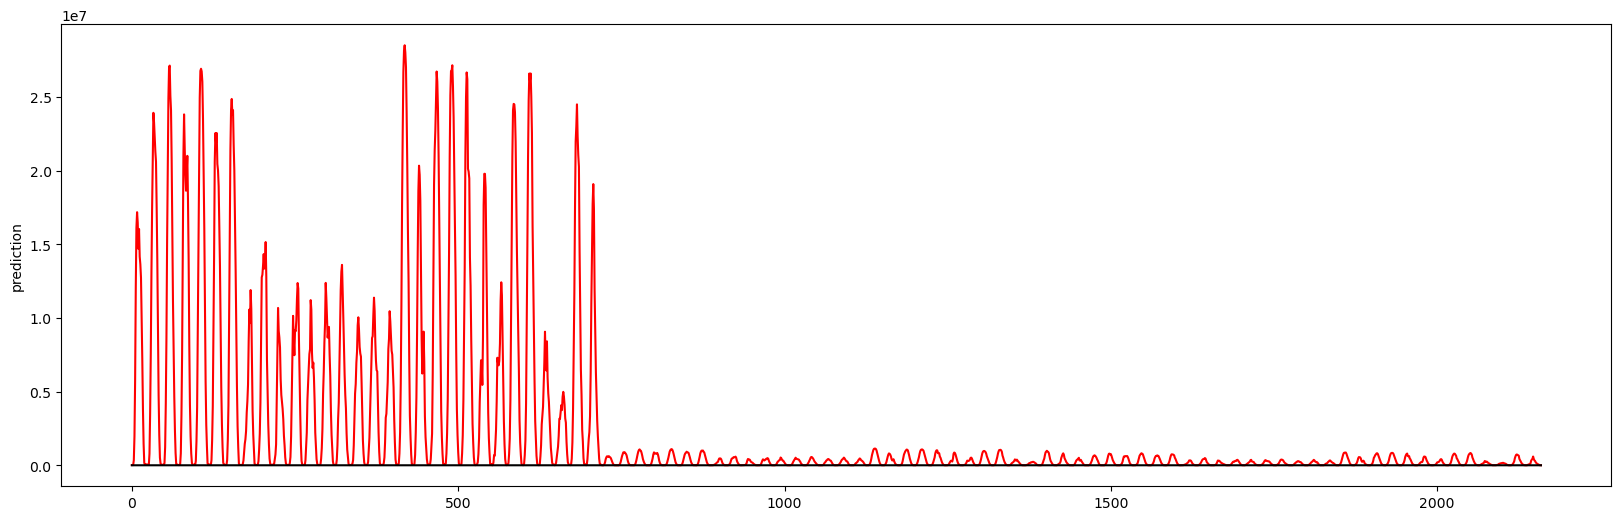

KeyError: 'hourDayMonthYear'

In [110]:
m_wrap.plot_yPredSub_vs_submission(predictions_mean, X_sub_agg)
m_wrap.y_pred_to_csv(predictions_mean,X_train_agg,True,'building_bagging.csv',1)

In [ ]:
predictions_mean

0    274.467289
dtype: float64